# 03a - Differential Abundance Analysis

## I. Preliminaries

Import the libraries and functions for model evaluation.

In [77]:
from scipy.stats import norm, false_discovery_control, mannwhitneyu
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import yaml
import pickle

from metaboDGD.src import model
from metaboDGD.src.latent import RepresentationLayer

In [16]:
metabolite_list = []

f = open('metabolite_list.txt', 'r')
for i in f:
    if i.strip() != 'cohort':
        metabolite_list.append(i.strip())
f.close()

In [17]:
normal_sample_list = []

f = open('normal_sample_list.txt', 'r')
for i in f:
    normal_sample_list.append(i)
f.close()

In [18]:
disease_sample_list = []
f = open('disease_sample_list.txt', 'r')
for i in f:
    disease_sample_list.append(i)
f.close()

In [ ]:
f = open('sept_outputs/results.pkl', 'rb')
results = pickle.load(f)
f.close()

np_normal_lbls = results['np_normal_lbls']
np_normal_log = results['np_normal_log']
cohorts_normal = results['cohorts_normal']

np_tumor_lbls = results['np_tumor_lbls']
np_tumor_log = results['np_tumor_log']
cohorts_tumor = results['cohorts_tumor']

In [5]:
config_model = yaml.safe_load(open('model.yaml', 'r'))
config_train = yaml.safe_load(open('train.yaml', 'r'))

dgd_final = model.MetaboDGD(**config_model)
dgd_final.dec.load_state_dict(torch.load('sept_outputs/torch_outputs_dec.pt'))
dgd_final.gmm.load_state_dict(torch.load('sept_outputs/torch_outputs_gmm.pt'))

train_rep_final = RepresentationLayer(values=torch.zeros(size=(np_normal_log.shape[0], dgd_final.gmm.dim)))
train_rep_final.load_state_dict(torch.load('sept_outputs/torch_outputs_train_rep.pt'))

<All keys matched successfully>

In [6]:
f = open('sept_outputs/tumor_results.pkl', 'rb')
tumor_results = pickle.load(f)
f.close()

tumor_rep_final = tumor_results['tumor_rep_final']
dec_out_final   = tumor_results['dec_out_final']

## II. Differential Abundance Analysis (1 vs. 1; Tumor vs. Generated Normal)

In [12]:
# Use decoder output and decoder's std for norm
coad_sample_idx = 200
loc = dec_out_final[coad_sample_idx,:]
scale = dgd_final.dec.normal_layer.std.detach().flatten().numpy()
norm_rv = norm(loc=loc, scale=scale)

# Get first sample
tumor_coad = np_tumor_log[coad_sample_idx]
gnorm_coad = np.copy(loc)

In [13]:
# Use observed abundance
p_vals = 2 * np.minimum(norm_rv.cdf(tumor_coad), 1-norm_rv.cdf(tumor_coad))
q_vals = false_discovery_control(p_vals, method='bh')
log2_fold_changes = (tumor_coad + 1e-6) / (gnorm_coad + 1e-6)

In [19]:
pd.DataFrame({
    'p_value': p_vals,
    'q_value': q_vals,
    'log2_fold_changes': log2_fold_changes
}, index=metabolite_list)

,p_value,q_value,log2_fold_changes
(+)-(S)-Carvone,1.000000,1.0,0.999996
"(+)-15,16-Dihydroxyoctadecanoic acid",0.956523,1.0,0.000006
"(+)-2,3-Dihydro-3-methyl-1H-pyrrole",1.000000,1.0,1.000000
(+)-7-Isojasmonic acid,0.999999,1.0,0.203948
(+)-Aschantin,0.999917,1.0,0.003279
...,...,...,...
¦Â-Alanine,1.000000,1.0,1.000000
¦Â-Estradiol,1.000000,1.0,1.000000
¦Â-Estradiol-17¦Â-glucuronide,1.000000,1.0,1.000000
¦Â-Muricholic acid,1.000000,1.0,1.000000


## III. Differential Abundance Analysis (1 vs. Many; Tumor vs. Real Normal)

In [20]:
# COAD Samples Only
normal_coad = np_normal_log[118:157,:]
tumor_coad = np_tumor_log[180:217,:]

In [22]:
p_val = mannwhitneyu(tumor_coad,normal_coad, alternative='two-sided').pvalue
q_val = false_discovery_control(p_val, method='bh')

## Figure 4B and 4C

Specificity

In [30]:
# COAD Samples Only
normal_coad = np_normal_log[118:157,:]

In [ ]:
rep_normal, dec_normal = dgd_final.get_representations(
                                        np_normal_log,
                                        np_normal_lbls,
                                        1192
                                    )

In [ ]:
random_coad_idx = np.random.choice(np.r_[118:157],size=10, replace=False)
other_coad_idx = np.array(list(set(np.r_[118:157]) - set(random_coad_idx)))

In [132]:
# Get number of DAMs at varying thresholds for each randomly chosen sample (1 vs. 1)
threshold = np.arange(0.01, 0.11, 0.01)
dam_counts = []
for t in threshold:
    dea_count_t = []
    for i in random_coad_idx:
        loc = dec_normal[i].detach().numpy()
        scale = dgd_final.dec.normal_layer.std.detach().flatten().numpy()
        norm_rv = norm(loc=loc, scale=scale)

        # Use observed abundance
        p_vals = 2 * np.minimum(norm_rv.cdf(np_normal_log[i]), 1-norm_rv.cdf(np_normal_log[i]))
        q_vals = false_discovery_control(p_vals, method='bh')

        dea_count_t.append(len(q_vals[q_vals<t]))
    dam_counts.append(np.array(dea_count_t))

In [ ]:
# Get number of DAMs by comparing generated normal 
p_vals = mannwhitneyu(np_normal_log[random_coad_idx], np_normal_log[other_coad_idx], alternative='two-sided').pvalue
q_vals = false_discovery_control(p_vals, method='bh')
mwu_dam_counts = []
for t in threshold:
    mwu_dam_counts.append(len(q_vals[q_vals<t]))

Plot 4B (Number of DAMs in varying intervals)

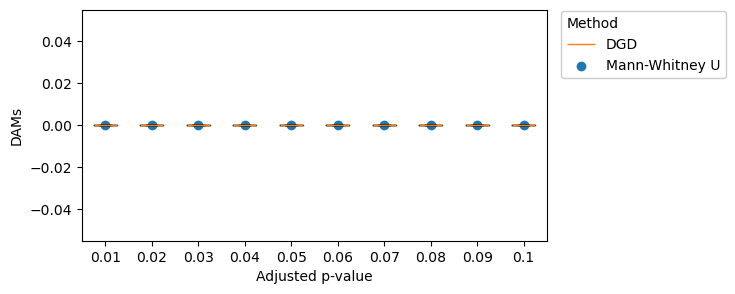

In [141]:
fig, ax = plt.subplots(figsize=(6,3))


ax.boxplot(dam_counts, label='DGD')
ax.scatter(np.arange(1,10+1), np.array(mwu_dam_counts),  marker='o', label='Mann-Whitney U')

ax.set_xticklabels(np.round(threshold, 2))
ax.set_xticks(np.arange(1,10+1), np.round(threshold, 2))
ax.set_xlabel("Adjusted p-value")
ax.set_ylabel("DAMs")

ax.legend(bbox_to_anchor=(1.4, 1.025),
               loc='upper right',
               framealpha=1.0,
               title='Method',
               alignment='left')
plt.show()